In [1]:
%load_ext autoreload
%autoreload 2

import traceback
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

In [3]:
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)
from keras import backend as K
K.set_session(sess)

In [4]:
from make_line_on_xray import get_xray

/home/yoyoteng/anaconda3/envs/py35tf/lib/python3.6/site-packages/skimage/transform/_warps.py:23: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '


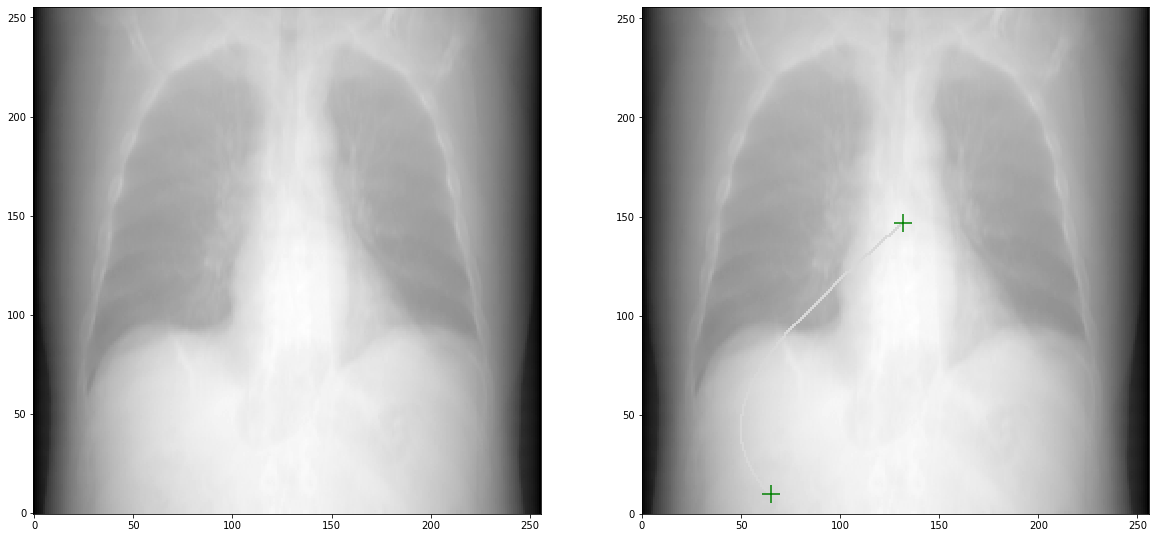

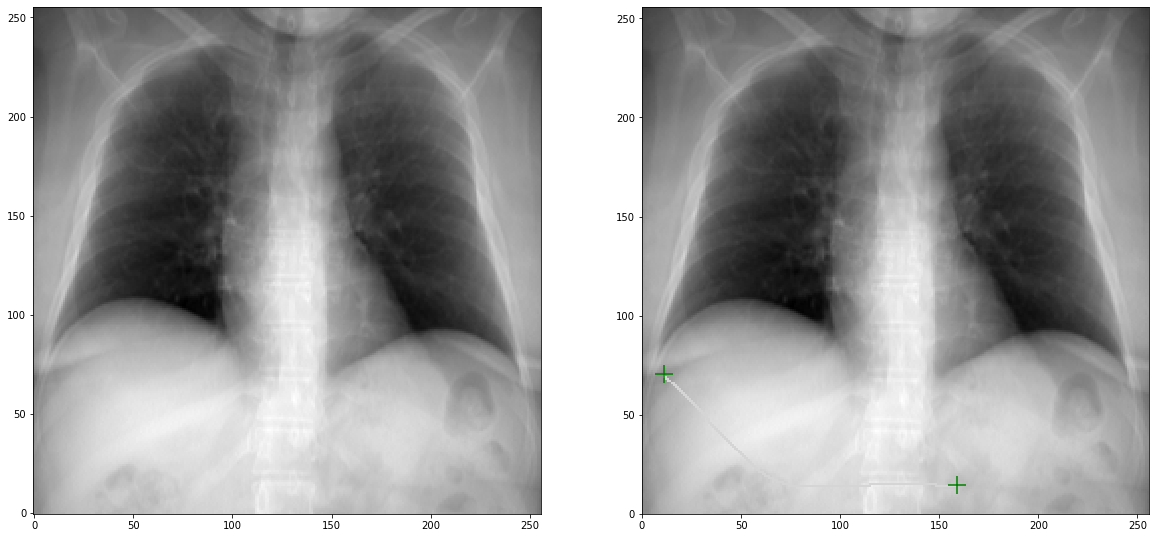

In [5]:
for n in range(2):
    try:
        xray, container = get_xray(isplot=True,fignum=n)
    except:
        pass
        traceback.print_exc()

In [8]:
from make_line_on_xray import (
    make_xray_data,
    get_grid, get_code,
)

from mask_yolo_model import (
    get_mask_yolo_model,
    dice_coef_loss,
    vec_loss,
    MASK, VECTOR,
    EarlyStopping,
    opt,
)

In [9]:
def viz_results(x_test,y_test0,y_test1,pred,szx,szy):
    obj_ind = -1
    #for ind in range(pred.shape[0]):
    for ind in range(5):

        plt.figure(ind,figsize=(20,10))
        #print(pred[0][ind,:,:,obj_ind])
        maxval = np.max(pred[0][ind,:,:,obj_ind])
        argmax = np.argwhere(pred[0][ind,:,:,obj_ind]==maxval)
        argmaxx,argmaxy=argmax[0]
        print(print(argmax.shape),argmax[0])
        
        print('pred',pred[0][ind,argmaxx,argmaxy,:])
        print('true',y_test0[ind,argmaxx,argmaxy,:])
        print('------')
        
        # GROUND TRUTH
        sa=plt.subplot(331)
        plt.title('sample index: {}, t:green, p:blue'.format(ind))
        sa.imshow(x_test[ind,:].squeeze(),cmap='gray')
        
        # overlay bounding box
        argmax = get_code(argmaxx,argmaxy,smx)
        ax,ay=grid_anchor[argmax]
        x,y,w,h,o = pred[0][ind,argmaxx,argmaxy,:]
        x,y,w,h,o = x*szx,y*szy,w*szx,h*szy,o
        x,y = ax+x,ay+y
        x,y = x-w/2.,y-h/2.
        rect = patches.Rectangle((y,x),h,w,linewidth=2,edgecolor='b',facecolor='none')
        sa.add_patch(rect)
        
        x,y,w,h,o = y_test0[ind,argmaxx,argmaxy,:]
        x,y,w,h,o = x*szx,y*szy,w*szx,h*szy,o
        x,y = ax+x,ay+y
        x,y = x-w/2.,y-h/2.
        rect = patches.Rectangle((y,x),h,w,linewidth=2,edgecolor='g',facecolor='none')
        sa.add_patch(rect)
        
        obj_real = y_test0[ind,:,:,obj_ind].squeeze()
        
        plt.subplot(335)
        plt.title('obj or not - truth'.format())
        plt.imshow(obj_real,cmap='gray')
        
        ax = plt.subplot(336)
        plt.title('obj or not - truth - actual val'.format())
        plt.plot(obj_real.ravel())
        plt.scatter(argmax,1,30,'b')
        ax.set_ylim(0,1)
        
        # PREDICTED
        
        obj = pred[0][ind,:,:,obj_ind].squeeze()
        
        plt.subplot(338)
        plt.title('obj or not - pred'.format())
        plt.imshow(obj,cmap='gray')
        
        ax = plt.subplot(339)
        plt.title('obj or not - pred - actual val'.format())
        plt.plot(obj.ravel())
        ax.set_ylim(0,1)
        
        if len(pred)>1:
            plt.subplot(334)
            plt.title('true-mask argmax:{}'.format(argmax))
            plt.imshow(y_test1[ind,:,:,argmax].squeeze(),cmap='gray')
            plt.subplot(337)
            plt.title('pred-mask argmax:{}'.format(argmax))
            plt.imshow(pred[1][ind,:,:,argmax].squeeze(),cmap='gray')
            

In [11]:
szx,szy,szz=256,256,256
smx,smy=8,8
# 256x128,64,32
x_train, y_train0, y_train1 = make_xray_data(N=100)
x_val, y_val0, y_val1 = make_xray_data(N=20)
x_test, y_test0, y_test1 = make_xray_data(N=5)
grid, grid_anchor = get_grid()

[[3 4]
 [4 4]
 [5 5]]
28 3 8 4 0
36 4 8 4 0
45 5 8 5 0


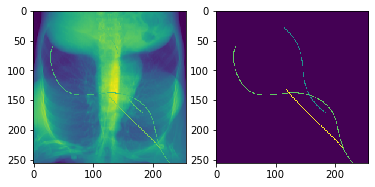

In [12]:
ind = -1
plt.subplot(121)
plt.imshow(x_train[ind,:].squeeze())

region = np.argwhere(y_train0[ind,:,:,-1]==1)
print(region)
tmp = np.zeros((szx,szy))
r=1
if len(region.squeeze().shape) > 0:
    for x,y in region:
        code = smx*x+y
        print(code,x,smx,y,np.sum(y_train1[ind,x,y,code]))
        tmp[y_train1[ind,:,:,code].squeeze()==1]=r+1
        r+=1
plt.subplot(122)
plt.imshow(tmp)

In [13]:
model = get_mask_yolo_model(szx,szy)
model.summary()

yolo_loss = {
    MASK: dice_coef_loss,
    VECTOR: vec_loss,
}
loss_weights = {
    MASK: 1.,
    VECTOR: 1.,
}

verbose=1
batch_size=16
epochs=1000
lr=1E-3
decay=1E-3
patience=10
beta_1=0.9
beta_2=0.999

early_stopping = EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=patience,
                              verbose=0,
                              mode='min')

callbacks = [early_stopping]
optimizer = opt.Adam(lr=lr,beta_1=beta_1, beta_2=beta_2, decay=decay)
model.compile(loss=yolo_loss, loss_weights=loss_weights, optimizer=optimizer)
history = model.fit(x_train, {VECTOR:y_train0,MASK:y_train1},
                    batch_size=batch_size, epochs=epochs,
                    verbose=verbose, 
                    validation_data=(x_val, {VECTOR:y_val0, MASK:y_val1}),
                    callbacks=callbacks)

# fixing dice,dice loss is nan, source data fixed.
# 1.37, 1.42
# decreased lr from 1E-3 to 1E-4
# not great visually, for got to jot down loss
# increased lr to 1E-3
# 1.85, 2.0
# 0.95, 1.42








Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 144         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 256, 256, 16) 64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 256, 256, 16) 0           batch_normalization_

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 100 samples, validate on 20 samples
Epoch 1/1000
100/100 [==============================] - 42s 417ms/step - loss: 6.7029 - VECTOR_loss: 1.5272 - MASK_loss: 0.9926 - val_loss: 6.4219 - val_VECTOR_loss: 1.3807 - val_MASK_loss: 0.9927
Epoch 2/1000
100/100 [==============================] - 11s 111ms/step - loss: 6.1951 - VECTOR_loss: 1.2325 - MASK_loss: 0.9926 - val_loss: 5.9877 - val_VECTOR_loss: 1.1530 - val_MASK_loss: 0.9927
Epoch 3/1000
100/100 [==============================] - 3s 30ms/step - loss: 5.7878 - VECTOR_loss: 1.0281 - MASK_loss: 0.9926 - val_loss: 5.5067 - val_VECTOR_loss: 0.8681 - val_MASK_loss: 0.9926
Epoch 4/1000
100/100 [==============================] - 3s 28ms/step - loss: 5.4193 - VECTOR_loss: 0.8511 - MASK_loss: 0.9925 - val_loss: 5.2035 - val_VECTOR_loss: 0.7489 - val_MASK_loss: 0.9926
Epoch 5/1000
100/100 [==============================] - 3s 28ms/step - loss: 

Epoch 41/1000
100/100 [==============================] - 3s 27ms/step - loss: 2.0524 - VECTOR_loss: 0.3084 - MASK_loss: 0.9861 - val_loss: 2.0551 - val_VECTOR_loss: 0.3202 - val_MASK_loss: 0.9917
Epoch 42/1000
100/100 [==============================] - 3s 28ms/step - loss: 2.0266 - VECTOR_loss: 0.3064 - MASK_loss: 0.9856 - val_loss: 2.0480 - val_VECTOR_loss: 0.3368 - val_MASK_loss: 0.9908
Epoch 43/1000
100/100 [==============================] - 3s 29ms/step - loss: 2.0011 - VECTOR_loss: 0.3044 - MASK_loss: 0.9846 - val_loss: 2.0216 - val_VECTOR_loss: 0.3306 - val_MASK_loss: 0.9923
Epoch 44/1000
100/100 [==============================] - 3s 27ms/step - loss: 1.9780 - VECTOR_loss: 0.3032 - MASK_loss: 0.9841 - val_loss: 1.9966 - val_VECTOR_loss: 0.3263 - val_MASK_loss: 0.9925
Epoch 45/1000
100/100 [==============================] - 3s 28ms/step - loss: 1.9507 - VECTOR_loss: 0.2961 - MASK_loss: 0.9844 - val_loss: 1.9729 - val_VECTOR_loss: 0.3226 - val_MASK_loss: 0.9925
Epoch 46/1000
100/10

Epoch 83/1000
100/100 [==============================] - 3s 28ms/step - loss: 1.4262 - VECTOR_loss: 0.2351 - MASK_loss: 0.8977 - val_loss: 1.6558 - val_VECTOR_loss: 0.4112 - val_MASK_loss: 0.9537
Epoch 84/1000
100/100 [==============================] - 3s 28ms/step - loss: 1.4204 - VECTOR_loss: 0.2315 - MASK_loss: 0.8995 - val_loss: 1.5681 - val_VECTOR_loss: 0.3550 - val_MASK_loss: 0.9260
Epoch 85/1000
100/100 [==============================] - 3s 28ms/step - loss: 1.4189 - VECTOR_loss: 0.2290 - MASK_loss: 0.9041 - val_loss: 1.5723 - val_VECTOR_loss: 0.3447 - val_MASK_loss: 0.9440
Epoch 86/1000
100/100 [==============================] - 3s 28ms/step - loss: 1.4108 - VECTOR_loss: 0.2241 - MASK_loss: 0.9043 - val_loss: 1.5645 - val_VECTOR_loss: 0.3674 - val_MASK_loss: 0.9170
Epoch 87/1000
100/100 [==============================] - 3s 28ms/step - loss: 1.3882 - VECTOR_loss: 0.2209 - MASK_loss: 0.8885 - val_loss: 1.5419 - val_VECTOR_loss: 0.3559 - val_MASK_loss: 0.9094
Epoch 88/1000
100/10

Epoch 125/1000
100/100 [==============================] - 3s 28ms/step - loss: 1.1568 - VECTOR_loss: 0.1667 - MASK_loss: 0.7826 - val_loss: 1.3882 - val_VECTOR_loss: 0.3296 - val_MASK_loss: 0.8516
Epoch 126/1000
100/100 [==============================] - 3s 28ms/step - loss: 1.1512 - VECTOR_loss: 0.1660 - MASK_loss: 0.7784 - val_loss: 1.3932 - val_VECTOR_loss: 0.3281 - val_MASK_loss: 0.8587
Epoch 127/1000
100/100 [==============================] - 3s 28ms/step - loss: 1.1294 - VECTOR_loss: 0.1629 - MASK_loss: 0.7605 - val_loss: 1.3713 - val_VECTOR_loss: 0.3129 - val_MASK_loss: 0.8529
Epoch 128/1000
100/100 [==============================] - 3s 28ms/step - loss: 1.1130 - VECTOR_loss: 0.1583 - MASK_loss: 0.7496 - val_loss: 1.4140 - val_VECTOR_loss: 0.3144 - val_MASK_loss: 0.8950
Epoch 129/1000
100/100 [==============================] - 3s 28ms/step - loss: 1.1096 - VECTOR_loss: 0.1511 - MASK_loss: 0.7542 - val_loss: 1.3512 - val_VECTOR_loss: 0.3013 - val_MASK_loss: 0.8464
Epoch 130/1000


In [23]:
#model.save('xray-line-yolo-model.h5')

yaml_file = 'xray_line_yolo/model.yml'
weight_file = 'xray_line_yolo/weight.hdf5'

model.save_weights(weight_file)
yaml_string = model.to_yaml()
with open(yaml_file,'w') as f:
    f.write(yaml_string)
with open(yaml_file,'r') as f:
    loaded_yaml_string = f.read()
    
from keras.models import model_from_yaml
model = model_from_yaml(loaded_yaml_string)
model.load_weights(weight_file)

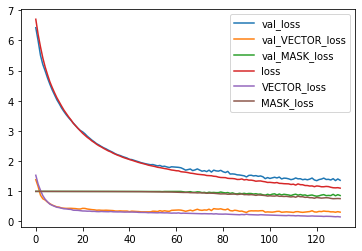

In [17]:
import pandas as pd
df = pd.DataFrame(history.history)
df.plot()

In [18]:
x_0, y_0, y_1 = x_train, y_train0, y_train1
out = model.evaluate(x_0,{VECTOR:y_0, MASK:y_1})
print('train',out)
x_0, y_0, y_1 = x_val, y_val0, y_val1
out = model.evaluate(x_0,{VECTOR:y_0, MASK:y_1})
print('val',out)
x_0, y_0, y_1 = x_test, y_test0, y_test1
out = model.evaluate(x_0,{VECTOR:y_0, MASK:y_1})
print('test',out)

100/100 [==============================] - 86s 856ms/step
train [1.1343882179260254, 0.2046639108657837, 0.7280764198303222]
20/20 [==============================] - 10s 508ms/step
val [1.3602080345153809, 0.30364757776260376, 0.8549124598503113]
5/5 [==============================] - 0s 20ms/step
test [1.3777332305908203, 0.2919582426548004, 0.8841269612312317]


(1, 2)
None [4 3]
pred [0.03037494 0.05430675 0.50941217 0.59564227 0.12774155]
true [0.06835938 0.00390625 0.67578125 0.2890625  1.        ]
------
(1, 2)
None [5 2]
pred [0.07838151 0.04884622 0.27924472 0.43363675 0.20946231]
true [0. 0. 0. 0. 0.]
------
(1, 2)
None [5 7]
pred [0.042799   0.0168733  0.18876034 0.21748579 0.00223133]
true [0. 0. 0. 0. 0.]
------
(1, 2)
None [4 2]
pred [0.03168818 0.03044987 0.55646616 0.49895135 0.09203619]
true [0.05078125 0.00195312 0.3125     0.50390625 1.        ]
------
(1, 2)
None [2 1]
pred [0.04618794 0.04344437 0.26126727 0.3090434  0.31545013]
true [0. 0. 0. 0. 0.]
------


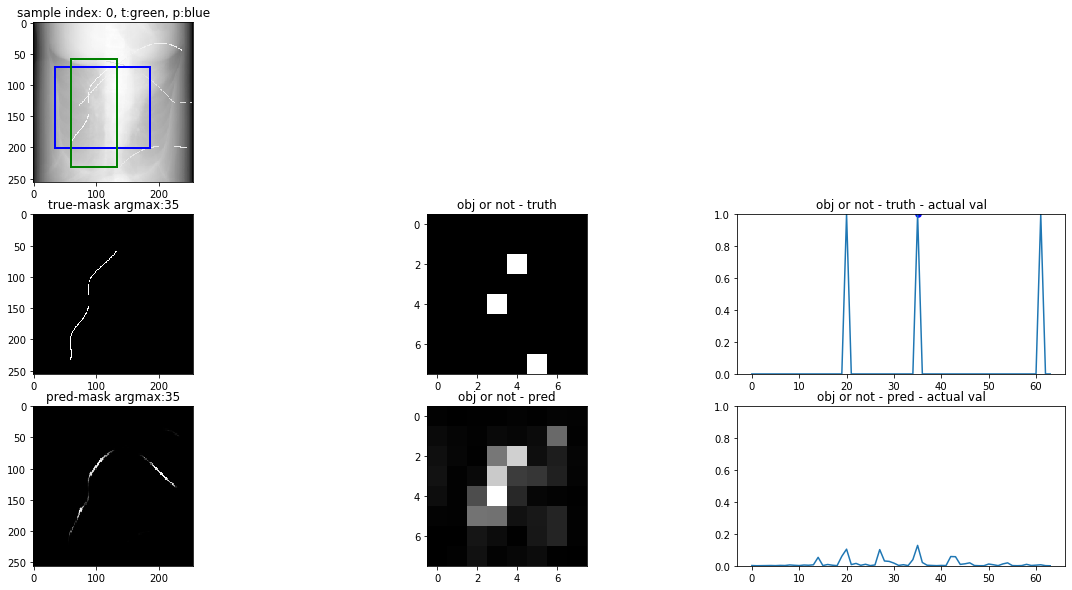

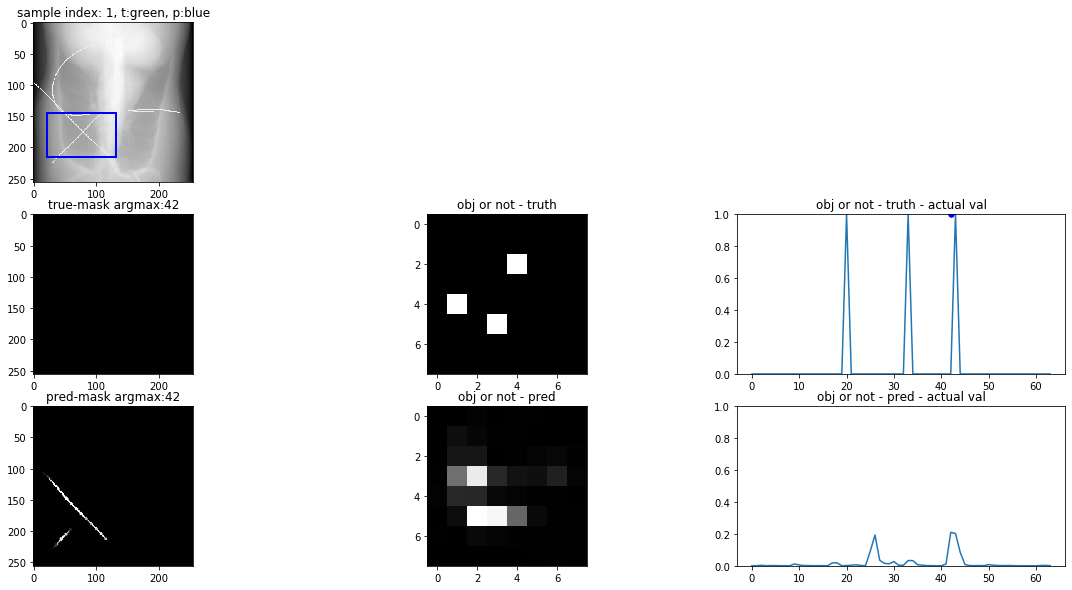

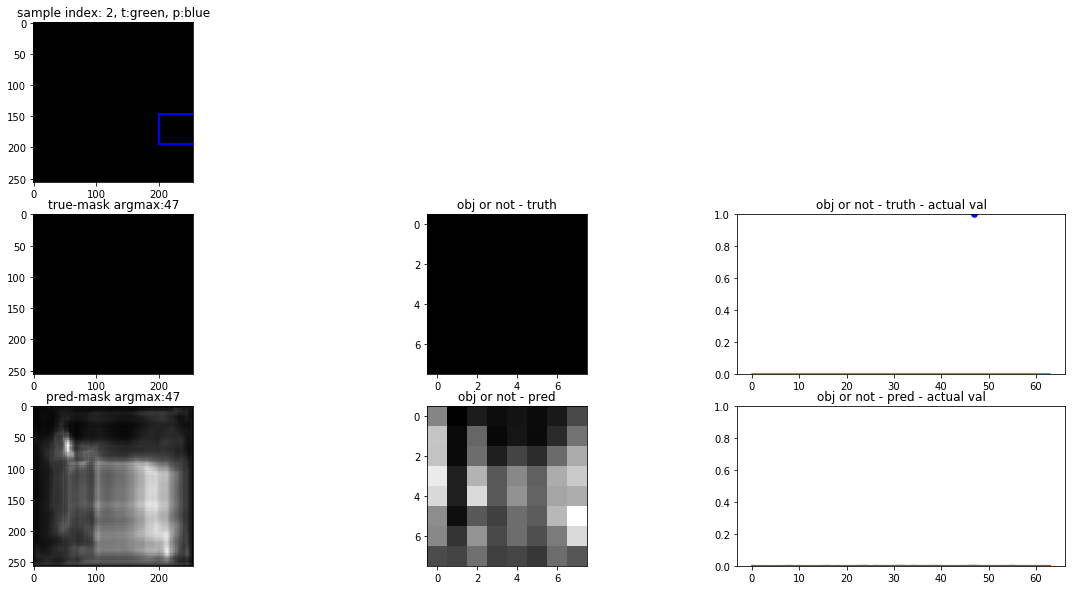

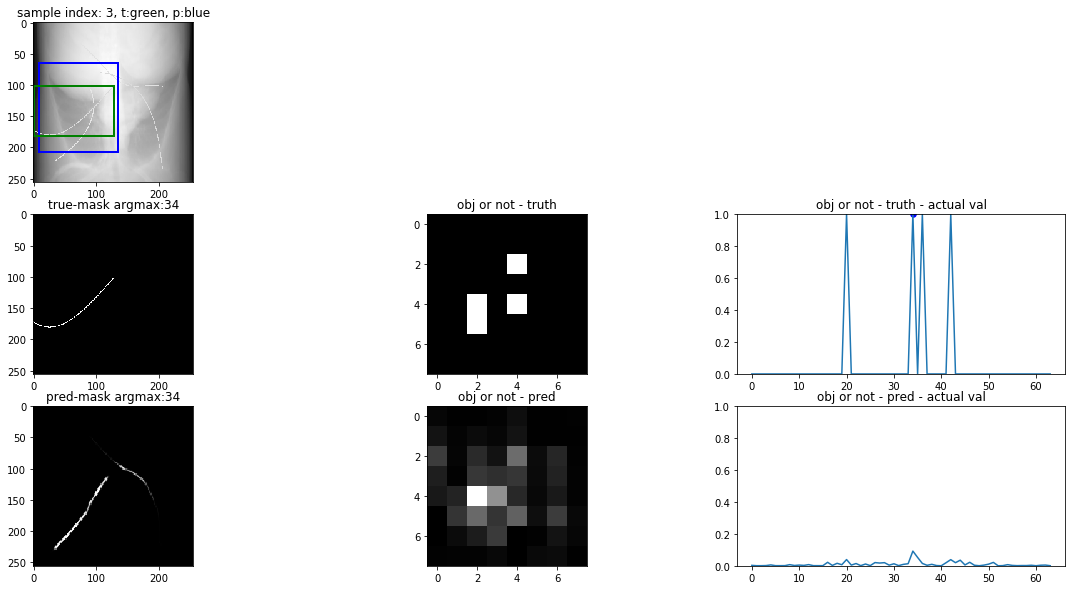

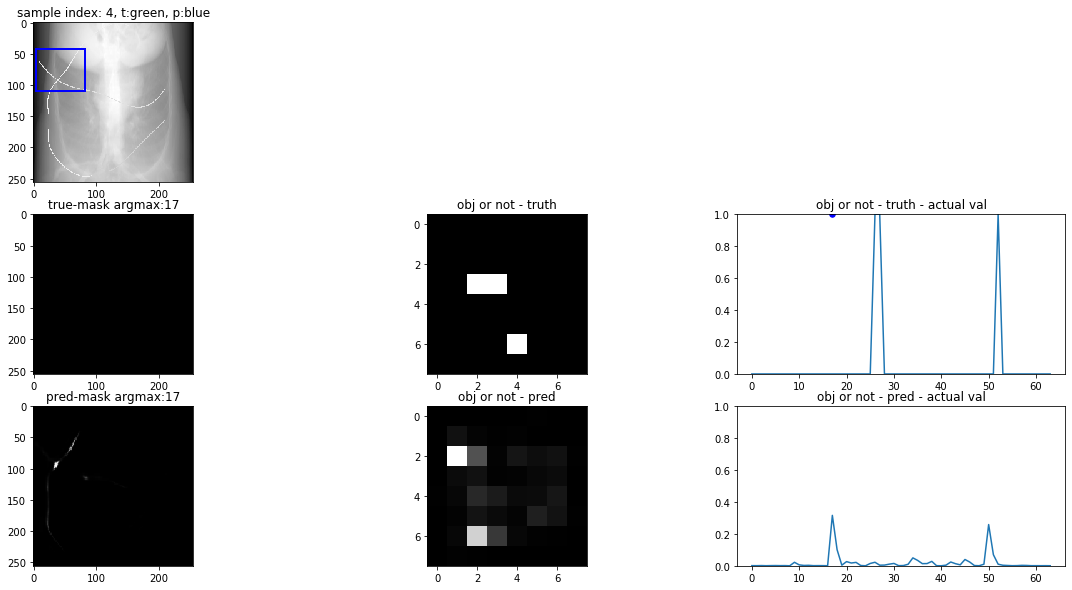

In [19]:
#x_0, y_0, y_1 = x_test, y_test0, y_test1
#x_0, y_0, y_1 = x_train, y_train0, y_train1
x_0, y_0, y_1 = x_val, y_val0, y_val1
pred = model.predict(x_0)
viz_results(x_0,y_0,y_1,pred,szx,szy)